In [48]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns

In [49]:
# URL of the Wikipedia page
url = "https://en.wikipedia.org/wiki/List_of_busiest_passenger_flight_routes"

# Send a GET request to fetch the page
response = requests.get(url)
soup = BeautifulSoup(response.content, "html.parser")

In [50]:
# Initialize a list to store the flight data
flights = []

In [51]:
# Function to clean passenger numbers (e.g., "1,234,567" -> "1234567")
def clean_passengers(passenger_text):
    return passenger_text.replace(",", "").strip()

In [52]:
def get_table_year(table):
    # Check preceding h2 or h3 for year
    caption = table.find_previous(["h2", "h3"])
    if caption:
        match = re.search(r"\b(20\d{2})\b", caption.text)
        if match:
            return match.group(1)
    # Fallback: Check table caption
    caption = table.find("caption")
    if caption:
        match = re.search(r"\b(20\d{2})\b", caption.text)
        if match:
            return match.group(1)
    return None  # Default if year not found

In [53]:
# Find all tables with class 'wikitable'
tables = soup.find_all("table", class_="wikitable")

In [54]:
# Process each table
for table in tables:
    # Determine the route type based on table context (e.g., Domestic or International)
    caption = table.find_previous(["h2", "h3"])
    route_type = "International"  # Default
    if caption and "Domestic" in caption.text:
        route_type = "Domestic"

    # Get table year from context
    table_year = get_table_year(table)

    # Get headers to identify column indices
    headers = table.find("tr").find_all(["th", "td"])
    col_indices = {
        "from": None,
        "to": None,
        "passengers": None,
        "year": None
    }

    # Identify relevant columns by header text
    for i, header in enumerate(headers):
        header_text = header.text.strip().lower()
        if "airport" in header_text or "city" in header_text:
            if col_indices["from"] is None:
                col_indices["from"] = i
            else:
                col_indices["to"] = i
        elif "passenger" in header_text:
            col_indices["passengers"] = i
        elif "year" in header_text:
            col_indices["year"] = i

    # Get all rows in the table body
    rows = table.find("tbody").find_all("tr")[1:]  # Skip header row

    for row in rows:
        cols = row.find_all("td")
        if len(cols) >= 3:  # Ensure enough columns
            # Extract From and To airports
            from_airport = cols[col_indices["from"]].text.strip() if col_indices["from"] is not None else None
            to_airport = cols[col_indices["to"]].text.strip() if col_indices["to"] is not None else None
            # Extract passengers
            passengers = clean_passengers(cols[col_indices["passengers"]].text.strip()) if col_indices["passengers"] is not None else None
            # Extract year (from column or table context)
            year = cols[col_indices["year"]].text.strip() if col_indices["year"] is not None else table_year

            # Append to flights list
            flights.append({
                "From": from_airport,
                "To": to_airport,
                "Type": route_type,
                "Year": year,
                "Passengers": passengers
            })

In [55]:
# Create a DataFrame
df = pd.DataFrame(flights)
df

,From,To,Type,Year,Passengers
0,None,None,International,None,None
1,None,None,International,None,None
2,None,None,International,None,None
3,None,None,International,None,None
4,None,None,International,None,None
...,...,...,...,...,...
488,"Atlanta, GA","Chicago, IL",International,2014,2720000
489,"Chicago, IL","Minneapolis, MN",International,2014,2720000
490,"Atlanta, GA","New York, NY",International,2014,2600000
491,"Atlanta, GA","Orlando, FL",International,2014,2620000


In [56]:
df.isna().sum()

From           55
To            166
Type            0
Year           95
Passengers    333
dtype: int64

In [57]:
df_cleaned = df.dropna()
df_cleaned

,From,To,Type,Year,Passengers
313,London,Dublin,International,2011,5106040
314,Moscow,Saint Petersburg,International,2011,5051518[23]
315,London,Amsterdam,International,2011,4920551
316,London,New York,International,2011,4869777
317,London,Dubai,International,2011,3630407
...,...,...,...,...,...
488,"Atlanta, GA","Chicago, IL",International,2014,2720000
489,"Chicago, IL","Minneapolis, MN",International,2014,2720000
490,"Atlanta, GA","New York, NY",International,2014,2600000
491,"Atlanta, GA","Orlando, FL",International,2014,2620000


C:\Users\Dell\AppData\Local\Temp\ipykernel_2916\1058776707.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned["Route"] = df_cleaned["From"] + " to " + df_cleaned["To"]
C:\Users\Dell\AppData\Local\Temp\ipykernel_2916\1058776707.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned["Passengers"] = pd.to_numeric(df_cleaned["Passengers"], errors="coerce")
C:\Users\Dell\AppData\Local\Temp\ipykernel_2916\1058776707.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecate

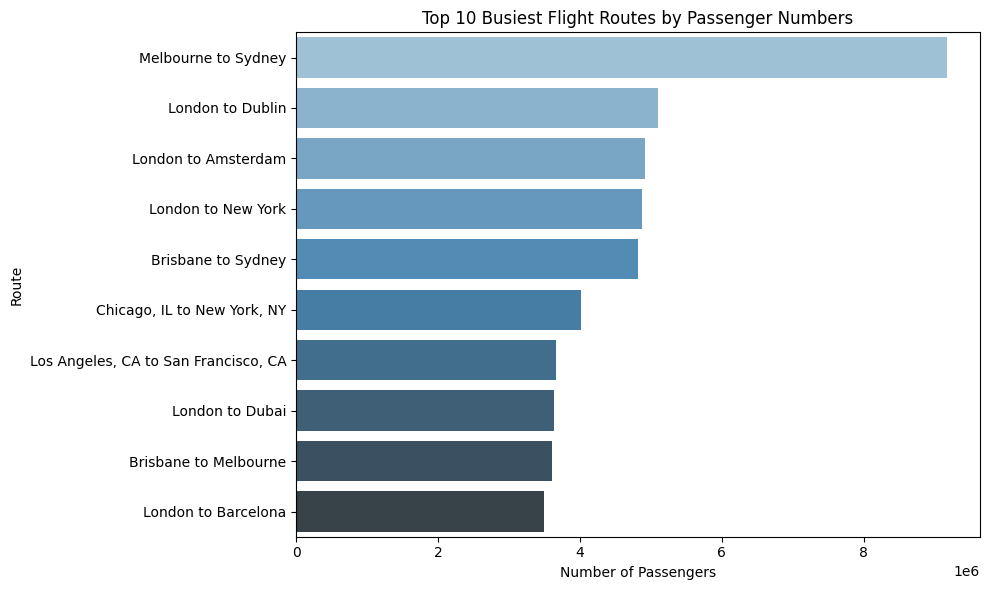

In [59]:
# Create a column for route names
df_cleaned["Route"] = df_cleaned["From"] + " to " + df_cleaned["To"]

# Ensure Passengers is numeric
df_cleaned["Passengers"] = pd.to_numeric(df_cleaned["Passengers"], errors="coerce")

# Filter out rows with zero or NaN passengers and sort by passengers
top_routes = df_cleaned[df_cleaned["Passengers"] > 0][["Route", "Passengers"]].sort_values(by="Passengers", ascending=False).head(10)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x="Passengers", y="Route", data=top_routes, palette="Blues_d")
plt.title("Top 10 Busiest Flight Routes by Passenger Numbers")
plt.xlabel("Number of Passengers")
plt.ylabel("Route")
plt.tight_layout()
plt.show()

C:\Users\Dell\AppData\Local\Temp\ipykernel_2916\2012019393.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned["Year"] = pd.to_numeric(df_cleaned["Year"], errors="coerce")
C:\Users\Dell\AppData\Local\Temp\ipykernel_2916\2012019393.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned["Passengers"] = pd.to_numeric(df_cleaned["Passengers"], errors="coerce")


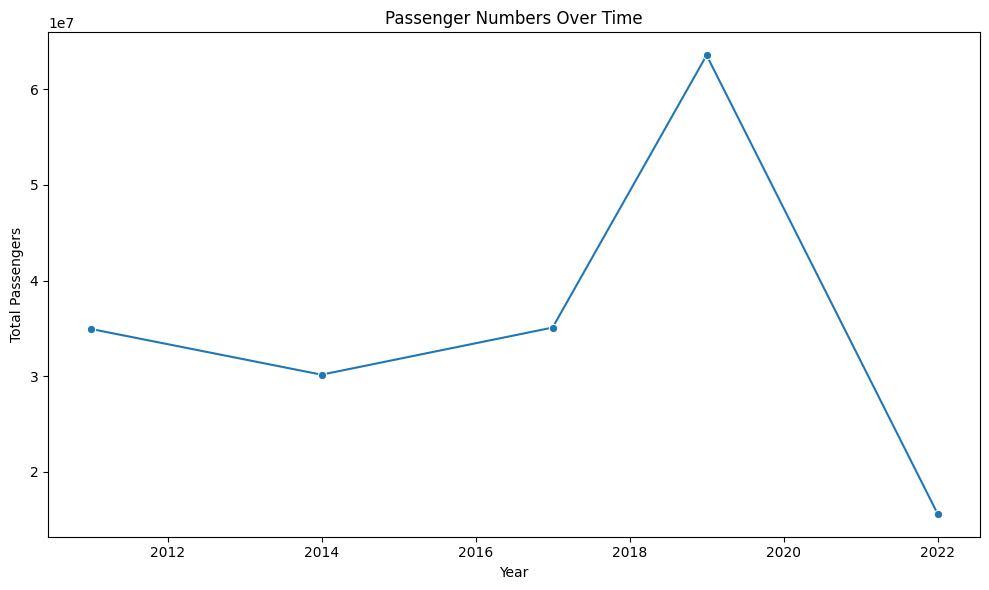

In [60]:
# Ensure Year and Passengers are numeric
df_cleaned["Year"] = pd.to_numeric(df_cleaned["Year"], errors="coerce")
df_cleaned["Passengers"] = pd.to_numeric(df_cleaned["Passengers"], errors="coerce")

# Filter out 'Unknown' or NaN years and zero/NaN passengers
df_time = df_cleaned[(df_cleaned["Year"].notna()) & (df_cleaned["Passengers"] > 0)]

# Group by year and sum passengers
passengers_by_year = df_time.groupby("Year")["Passengers"].sum().reset_index()

# Plot
plt.figure(figsize=(10, 6))
sns.lineplot(x="Year", y="Passengers", data=passengers_by_year, marker="o")
plt.title("Passenger Numbers Over Time")
plt.xlabel("Year")
plt.ylabel("Total Passengers")
plt.tight_layout()
plt.show()